# Image classification on [Cats-vs-Dogs](https://www.kaggle.com/competitions/dogs-vs-cats) dataset

_Image classification models in a data-poor context_

---

This tutorial is highly inspired by the [blog](https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html) from [François Chollet](https://fchollet.com/)  at the initiative of [`Keras`](https://keras.io/).

In this tutorial you will learn to : 
* Use convolutional networks to  build image classifiers on color images
* Use pre-trained models ($\texttt{VGG}$, $\texttt{Inception}$, _etc._) to improve the accuracy of the results
* Fine-Tuned pre-trained models
<!--* Cross-validation-->

In this tutorial, we focus on the (seemingly) simple problem of recognizing dogs and cats in images.

## Libraries

In [1]:
# Utils
import os
import shutil
import time

# Maths - Stats
from sklearn.utils import shuffle
import numpy as np
import pandas as pd
import random as rd

# Data visualization
from matplotlib import pyplot as plt
import seaborn as sns

# Deep Learning Librairies
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

2024-10-02 17:55:27.482221: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-02 17:55:27.502572: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-02 17:55:27.508522: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-02 17:55:27.524371: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-02 17:55:31.186981: W tensorflow/comp

These code lines allow you to check if your computer is using CPU or GPU ressources. <br>
**Warning** : You won't be able to use GPU if another notebook is open and still uses GPU.

In [2]:
# tf.config.list_physical_devices()
[k.device_type for k in tf.config.list_physical_devices()]

['CPU', 'GPU']

## Dataset

The dataset used in this TP is the [$\texttt{Cats-vs-Dogs}$](https://www.kaggle.com/competitions/dogs-vs-cats) dataset used in a [Kaggle Contest](https://www.kaggle.com/c/dogs-vs-cats) which contains 25.000 images. It is a huge number when you do not have a lot of computation power. 

As our goal here is to understand behaviour of algorithms and not to achieve the best performances, we have created a subsample of this dataset which are available following repository:

In [3]:
!git clone https://plmlab.math.cnrs.fr/chevallier-teaching/datasets/cats-vs-dogs.git

fatal: le chemin de destination 'cats-vs-dogs' existe déjà et n'est pas un répertoire vide.


### Dataset organisation

Our data are organized this way :

```
cats-vs-dogs
└───train/
│   └───cats/
│   │   │   cat.0.jpg
│   │   │   cat.1.jpg
│   │   │   ...
│   └───dogs/
│   │   │   dog.0.jpg
│   │   │   dog.1.jpg
│   │   │   ...
│   validation/
│   │   cat.1500.jpg
│   │   cat.1501.jpg
│   │   ...
│   │   dog.1500.jpg
│   │   dog.1501.jpg
│   │   ...
│   test/
│   │   cat.1000.jpg
│   │   cat.1001.jpg
│   │   ...
│   │   dog.1000.jpg
│   │   dog.1001.jpg
│   │   ...
```

In [4]:
path = "./cats-vs-dogs/"

The following cells can be used to load data in a suitable format:
* **Step 1**: Creation of $\texttt{lists}$ containing the image names of the training, validation and test sets, as well as the associated labels (0: cat, 1:dog);
* **Step 2**: Creation of $\texttt{dataframes}$ to enable data to be loaded as required.

#### Step 1: Creation of lists

In [5]:
# Training images
train_filenames_dogs = os.listdir(path + "train/dogs")
train_filenames_cats = os.listdir(path + "train/cats")
if not os.path.exists(path + "train/train"):
    os.mkdir(path + "train/train")

path_train = path + "train/"
for filename in train_filenames_cats:
    shutil.copyfile(path_train+"cats/"+filename, path_train+"train/"+filename)
for filename in train_filenames_dogs:
    shutil.copyfile(path_train+"dogs/"+filename, path_train+"train/"+filename)

train_filenames = os.listdir(path + "train/train")
train_categories =[]
for filename in train_filenames:
    category = filename.split('.')[0]
    if category == 'dog':
        train_categories.append(1)
    else:
        train_categories.append(0)


# Validation images
validation_filenames = os.listdir(path +"validation/")
validation_categories=[]
for filename in validation_filenames:
    category = filename.split('.')[0]
    if category == 'dog':
        validation_categories.append(1)
    else:
        validation_categories.append(0)


# Test images
test_filenames = os.listdir(path + "test/")
test_categories = []
for filename in test_filenames:
    category = filename.split('.')[0]
    if category == 'dog':
        test_categories.append(1)
    else:
        test_categories.append(0)

#### Step 2: Creation of dataframe

In [6]:
# Training images
total_train_df = pd.DataFrame({
    'filename': train_filenames,
    'category': train_categories
})


# Validation images
total_validation_df = pd.DataFrame({
    'filename': validation_filenames,
    'category': validation_categories
})


# Test images
test_df = pd.DataFrame({
    'filename': test_filenames,
    'category': test_categories
})


total_train_df['category'] = total_train_df['category'].astype(str)
total_validation_df['category'] = total_validation_df['category'].astype(str)
test_df['category'] = test_df['category'].astype(str)

##### <i style="color:purple">**Question:** How many training, validation and test images are available in this dataset?</i>

In [7]:
### TO BE COMPLETED ###

N_total_train = total_train_df.shape[0]
N_total_validation = total_validation_df.shape[0]
N_total_test = test_df.shape[0]

print("N_total_train =", N_total_train)
print("N_total_validation = ", N_total_validation)
print("N_total_test =", N_total_test)


N_total_train = 2000
N_total_validation =  1000
N_total_test = 1000


In [8]:
# %load solutions/CatsDogs/data_size.py
total_train = total_train_df.shape[0]
total_validation = total_validation_df.shape[0]
total_test = test_df.shape[0]

print("We have %d training data, %d validation data and %d test data, both labels combined." % 
      (total_train, total_validation, total_test))

We have 2000 training data, 1000 validation data and 1000 test data, both labels combined.


##### <i style="color:purple">**Question**: Is the data set balanced?</i>

In other words, do each of the train, test and validation sets contain as many cat images as dog images?

In [9]:
### TO BE COMPLETED ###

ratio_train = np.sum(train_categories)/N_total_train
ratio_validation = np.sum(validation_categories)/N_total_validation
ratio_test = np.sum(test_categories)/N_total_test

print("ratio_train =", ratio_train)
print("ratio_validation =", ratio_validation)
print("ratio_test =", ratio_test)

ratio_train = 0.5
ratio_validation = 0.5
ratio_test = 0.5


In [10]:
# %load solutions/CatsDogs/data_ratio.py

Given the large size of this dataset, we may need to consider only a subsample of it, to speed up training. 
Two parameters, $N_\text{train}$ and $N_\text{validation}$, indicate respectively the number of training and validation data to be taken into account for training.

In [11]:
partial = 0

if partial:
    # Even numbers required
    N_train = 200   # 1000, 2000
    N_validation = 100   # 500, 1000
else:
    N_train = total_train
    N_test = total_test

In [12]:
if N_train == total_train:
    train_df = total_train_df
    validation_df = total_validation_df
else:
    N = int(.5*N_train)
    train_df = pd.concat([total_train_df[total_train_df['category']=='1'][:N], 
                          total_train_df[total_train_df['category']=='0'][:N]])
    train_df.sort_index(inplace=True)
    N = int(.5*N_validation)
    validation_df = pd.concat([total_validation_df[total_validation_df['category']=='1'][:N], 
                          total_validation_df[total_validation_df['category']=='0'][:N]])
    del N

display(train_df)

,filename,category
0,cat.0.jpg,0
1,cat.1.jpg,0
2,cat.10.jpg,0
3,cat.100.jpg,0
4,cat.101.jpg,0
...,...,...
1995,dog.995.jpg,1
1996,dog.996.jpg,1
1997,dog.997.jpg,1
1998,dog.998.jpg,1


### Data visualization

In [13]:
from tensorflow.keras.utils import load_img, img_to_array

* The $\texttt{load\_img}$ function allows to load an image as a [PIL](https://he-arc.github.io/livre-python/pillow/index.html) image.
* The function $\texttt{img\_to\_array}$ generates an numpy array from a  PIL image.

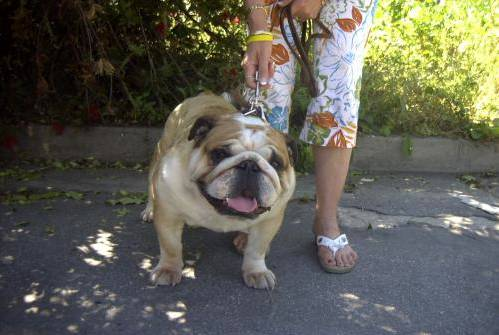

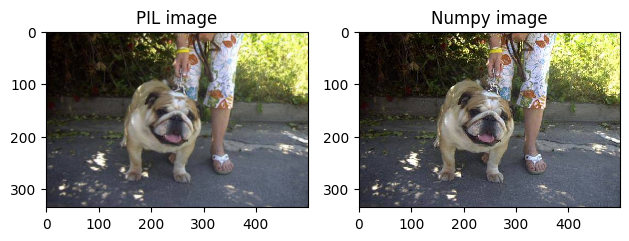

dimension (335, 499, 3)


In [14]:
filename = rd.choice(train_df['filename'])
img = load_img(path + "train/train/" + filename)

display(img)

plt.subplot(1,2,1)
plt.imshow(img)
plt.title("PIL image")

plt.subplot(1,2,2)
x = img_to_array(img)
plt.imshow(x/255, interpolation='nearest')
plt.title("Numpy image")

plt.tight_layout()
plt.show()

print("dimension", x.shape)

##### <i style="color:purple">**Question**: What are the dimensions of the $x$ array?</i>

To what correspond these dimensions? Ses dimensions sont (378, 450, 3) (x, y, couleurs)

##### <i style="color:purple">**Question**: Does the shape of the images fluctuate?</i>

This question can be answered by producing a boxplot of widths and heights respectively.

{'whiskers': [<matplotlib.lines.Line2D at 0x7eab41c8a980>,
 'caps': [<matplotlib.lines.Line2D at 0x7eab41c8aec0>,
 'boxes': [<matplotlib.lines.Line2D at 0x7eab41c8a6e0>],
 'medians': [<matplotlib.lines.Line2D at 0x7eab41c8b400>],
 'fliers': [<matplotlib.lines.Line2D at 0x7eab41c8b6a0>],
 'means': []}

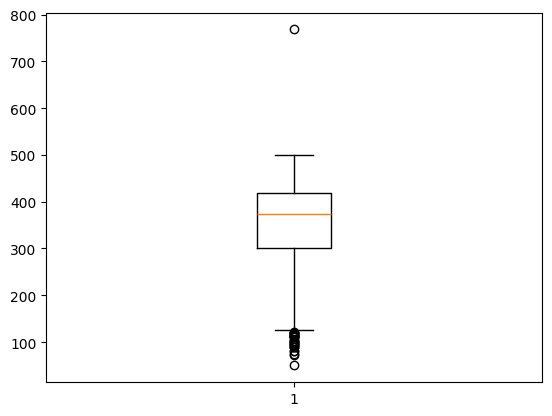

In [15]:
### TO BE COMPLETED ###
X = []
for i in train_df['filename']:
    img = load_img(path + "train/train/" + i)
    x = img_to_array(img)
    X.append(x.shape[0])
    
plt.boxplot(X)

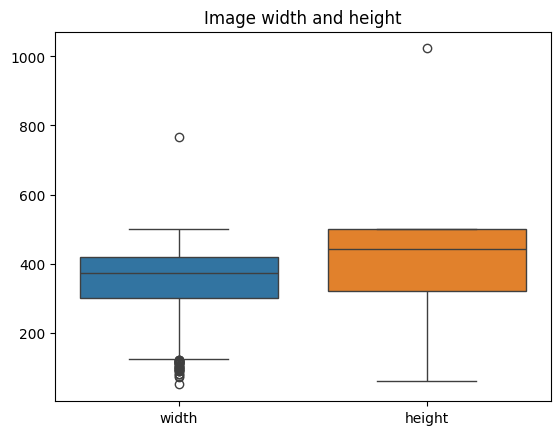

In [16]:
# %load solutions/CatsDogs/data_shape.py
img_size = np.zeros((train_df.shape[0],2))
for i, filename in enumerate(train_df['filename']) :
    img = img_to_array( load_img(path + "train/train/" + filename) )
    img_size[i,:] = img.shape[:2]

# --- #

plt.figure()
ax = sns.boxplot(img_size)
ax.set_xticks(ax.get_xticks())
ax.set_xticklabels(['width', 'height'])
plt.title("Image width and height")
plt.show()

## Pre-processing

In [17]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

Images have various dimensions, which is annoying because all images must have the same dimension to be used in this network. 
Next, we will impose a common image size.

The $\texttt{ImageDataGenerator}$ `keras`function allows to apply different treatments on the images (transformation, normalisation). This transformation allows to produce tranformation on the images without saving a lot of changed images on the disk. 

The syntax below defines _"generators"_ for each dataset, which load a predefined number of images (this will be our batch size) from the $\texttt{dataframes}$ defined above.

We also define a target image size (here, $150\times150$) and a normalization pre-processing (division by 255).
<br><br>


> **Remark**: _Choice of $\,\texttt{batch\_size}$_ <br>
> When using keras generator, size of the batch should be a divider of the size of the sample, otherwise algorithms produce very unstable results in training phase.

In [18]:
batch_size = 20  # divider of N_train and N_validation
img_width = 150
img_height = 150

# Training images
train_datagen = ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow_from_dataframe(
    train_df,
    path + "train/train/",
    x_col = 'filename',
    y_col = 'category',
    target_size = (img_width, img_height),
    class_mode = 'binary',
    batch_size = batch_size
)

# Validation images
validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_dataframe(
    validation_df,
    path + "validation/",
    x_col = 'filename',
    y_col = 'category',
    class_mode = 'binary',
    target_size = (img_width, img_height),
    batch_size = batch_size
)

# Test images
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_dataframe(
    test_df,
    path + "test/",
    x_col = 'filename',
    y_col = 'category',
    class_mode = 'binary',
    target_size = (img_width, img_height),
    batch_size = batch_size
)

Found 2000 validated image filenames belonging to 2 classes.
Found 1000 validated image filenames belonging to 2 classes.
Found 1000 validated image filenames belonging to 2 classes.


In [19]:
labels= {0: 'Cat', 1: 'Dog'}
labels.get(0), labels.get(1)

('Cat', 'Dog')

##### <i style="color:purple">**Exercise** : View a sample of images.</i>

Select 9 images from the training dataset, and display them with their respective labels as titles. The code below shows an example of how to use the generators defined above.

In [20]:
for x_batch, y_batch in train_generator:
    print(x_batch.shape)
    print(y_batch.shape)
    print(y_batch)
    break

(20, 150, 150, 3)
(20,)
[1. 0. 1. 0. 0. 0. 1. 0. 1. 0. 1. 1. 1. 1. 1. 0. 0. 1. 1. 0.]


In [ ]:
# %load solutions/CatsDo/home/gadj/.conda/envs/tensorflow/lib/python3.10/site-packages/keras/src/legacy/preprocessing/image.py:920: UserWarning: Found 8446 invalid image filename(s) in x_col="filename". These filename(s) will be ignored.
  warnings.warn(gs/data_visualization.py
plt.figure(figsize=(12, 12))

for i in range(9):
    plt.subplot(3, 3, i+1)
    for x_batch, y_batch in train_generator:
        img = x_batch[0]
        plt.title(labels.get(y_batch[0]))
        plt.imshow(img)
        plt.axis('off')
        plt.grid(False)
        break

plt.tight_layout()
plt.show()

## First approach: Basic convolutional network

We will here build a classifier with a custom architecture of a convolutional network.

### Model architecture

The images have all been resized to $150\times150$. We can therefore define a convolutional neural network following this scheme:
In the first phase, this network alternates between convolution and Max Pooling layers (in order to divide the dimension of the tensors by 2 each time).

<center><img src="img/CatsDogsCNN.png" style="width:700;height:350px;"></center>
<caption><center><b> View of architecture to be implemented </b></center></caption>

<br><br>

The model we define is composed of 3 convolution blocks with the following form: 
* A $\texttt{Conv2D}$ layer with $3\times3$ filters and a $\texttt{Relu}$ activation function.<br>
The first layer will have 32 convolution filters, the second 64, the third 96 (and the fourth 128).
* A $\texttt{MaxPooling}$ layer with $2\times2$ window.

Followed by:
* A $\texttt{flatten}$ layer.
* A $\texttt{Dense}$ layer with 64 (or 512) neurons and a Relu activation function.
* A $\texttt{Dropout}$ layer with a 50% drop rate.
* A $\texttt{Dense}$ layer with 1 neuron and a $\texttt{softmax}$ activation function.

You will have built a 6-layer network, a simplified version of $\texttt{AlexNet}$.

To build this network, you can use the $\texttt{Conv2D}$, $\texttt{Maxpooling2D}$ and $\texttt{Flatten}$ functions in `Keras`.

In [33]:
### TO BE COMPLETED ###

cnn_simple = Sequential()
cnn_simple.add(Input(shape=(150,150, 3)))
cnn_simple.add(Conv2D(32, kernel_size=(3, 3), activation='relu', data_format="channels_last"))
cnn_simple.add(MaxPooling2D(pool_size=(2, 2)))
cnn_simple.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
cnn_simple.add(MaxPooling2D(pool_size=(2, 2)))
cnn_simple.add(Conv2D(96, kernel_size=(3, 3), activation='relu'))
cnn_simple.add(MaxPooling2D(pool_size=(2, 2)))
cnn_simple.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
cnn_simple.add(MaxPooling2D(pool_size=(2, 2)))
cnn_simple.add(Flatten())    # Vectorization of the tensor to connect it to a dense layer
cnn_simple.add(Dense(64, activation='relu'))
cnn_simple.add(Dropout(0.5))
cnn_simple.add(Dense(1, activation='sigmoid'))

cnn_simple.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_15 (Conv2D)              │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 34, 34, 96)     │        55,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 17, 17, 96)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_18 (Conv2D)              │ (None, 15, 15, 128)    │       110,720 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_15 (MaxPooling2D) │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 6272)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 64)             │       401,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 587,041 (2.24 MB)

 Trainable params: 587,041 (2.24 MB)

 Non-trainable params: 0 (0.00 B)

In [34]:
# %load solutions/CatsDogs/CNN_model.py

#### Training

As our problem here is a two classes classifier we will use the $\texttt{binary\_crossentropy}$ loss function.

In [35]:
cnn_simple.compile(
    loss = 'binary_crossentropy',
    optimizer = Adam(learning_rate=3e-4),
    metrics = ['accuracy'])

* $\texttt{batch\_size}$:
Note that the batch size has already been defined when setting `keras` $\texttt{ImageDataGenerator}$. Recall that when using keras generator, size of the batch should be a divider of the size of the sample, otherwise algorithms produce very unstable results.

So, we only need to define a number of epochs.


* $\texttt{epochs}$:
Start with a small number (5-10) in order to check that computing time is reasonable.

In [36]:
epochs = 10

t_learning_cnn_simple = time.time()
cnn_simple_history = cnn_simple.fit(
    train_generator,
    validation_data = validation_generator,
    epochs = epochs
)
t_learning_cnn_simple = time.time() - t_learning_cnn_simple

print("Learning time for %d epochs : %d seconds" % (epochs, t_learning_cnn_simple))

Epoch 1/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 81ms/step - accuracy: 0.5151 - loss: 0.6952 - val_accuracy: 0.5000 - val_loss: 0.6877
Epoch 2/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 8s 78ms/step - accuracy: 0.5570 - loss: 0.6882 - val_accuracy: 0.6110 - val_loss: 0.6564
Epoch 3/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 8s 78ms/step - accuracy: 0.6273 - loss: 0.6453 - val_accuracy: 0.6380 - val_loss: 0.6340
Epoch 4/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 9s 90ms/step - accuracy: 0.6740 - loss: 0.6053 - val_accuracy: 0.6940 - val_loss: 0.5930
Epoch 5/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 9s 83ms/step - accuracy: 0.6949 - loss: 0.5740 - val_accuracy: 0.6870 - val_loss: 0.5944
Epoch 6/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 9s 83ms/step - accuracy: 0.7202 - loss: 0.5408 - val_accuracy: 0.7140 - val_loss: 0.5894
Epoch 7/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 8s 78ms/step - accuracy: 0.7703 - loss: 0.5028 - val_accuracy: 0.7240 - val_loss: 0.5442
Epoch 8/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 8s 77ms/step - accuracy: 0.8001 - loss: 0.4601 - val_acc

#### Analysis of results

In [37]:
t_prediction_cnn_simple = time.time()

score_cnn_train = cnn_simple.evaluate(train_generator, verbose=1)
score_cnn_validation = cnn_simple.evaluate(validation_generator, verbose=1)

t_prediction_cnn_simple = time.time() - t_prediction_cnn_simple

print('Train accuracy:', score_cnn_train[1])
print('Validation accuracy:', score_cnn_validation[1])
print("Time Prediction: %.2f seconds" % t_prediction_cnn_simple )

100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 53ms/step - accuracy: 0.8375 - loss: 0.3734
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 56ms/step - accuracy: 0.6980 - loss: 0.5678
Train accuracy: 0.8314999938011169
Validation accuracy: 0.703000009059906
Time Prediction: 8.54 seconds


##### <i style="color:purple">**Exercise**: Visualize the evolution of metrics during training.</i>

Write a function to display the evolution of metrics during training, on the training and validation sets. Display accuracy and loss on separate figures.

In [ ]:
### TO BE COMPLETED ###

def plot_training_analysis():
    [...]

In [39]:
# %load solutions/CatsDogs/plot_training_analysis.py
def plot_training_analysis(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(acc))

    plt.subplot(1,2,1)
    plt.plot(epochs, acc, 'b', linestyle="--",label='Training accuracy')
    plt.plot(epochs, val_acc, 'g', label='Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(epochs, loss, 'b', linestyle="--",label='Training loss')
    plt.plot(epochs, val_loss,'g', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

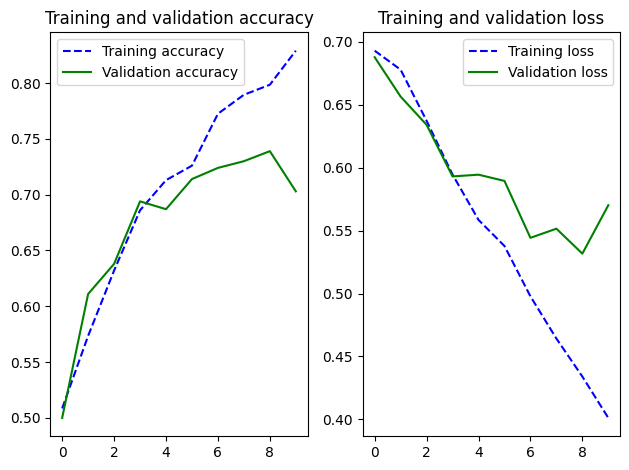

In [40]:
plot_training_analysis(cnn_simple_history)

##### <i style="color:purple">**Question** : What phenomenon are you dealing with?</i>

### Overfitting correction 

With the previous network, we were in a typical **overfitting** situation. This is a classic problem when working with small databases in deep learning.
Actually, the network you have created normally contains several million parameters (if you've followed the instructions). The problem you are trying to solve during training is establishing 1.8 million parameters with just 2,000 examples: that is too few!

To limit this overfitting, we can apply the regularization techniques. In image processing, one of the most commonly used techniques is **data augmentation**.

We are going to take the $\texttt{ImageDataGenerator}$ created earlier to normalize images and use it to apply additional transformations to the images in our database. You can refer to the [documentation](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator) to find out what the parameters below correspond to.

In [ ]:
ImageDataGenerator?

In [ ]:
train_datagen_augmented = ImageDataGenerator(
    rotation_range = 40,
    rescale = 1./255,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True,
    fill_mode='nearest'
)

train_generator_augmented = train_datagen_augmented.flow_from_dataframe(
    train_df,
    path + 'train/train/',
    x_col ='filename',
    y_col ='category',
    target_size=(img_width,img_height),
    class_mode = 'binary',
    batch_size = batch_size
)

##### <i style="color:purple">**Question**: Why do we apply different transformations for learning and validation?</i>

Indeed, we do not define a new generator for the validation set.

In the next cell, you can view images that have passed through our data augmentation loop. Observe how missing values in the images (for example, in the case of rotation) are filled in.

In [ ]:
plt.figure(figsize=(12, 12))

example_x, example_y = next(train_generator_augmented)

for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.imshow(example_x[i])
    plt.title(labels.get(example_y[i]))

plt.tight_layout()
plt.show()

#### Training

We can now rebuild our model and start training again.

In [ ]:
### TO BE COMPLETED ###

cnn_simple = Sequential()
[...]

cnn_simple.summary()

# --- #

### TO BE COMPLETED ###
epochs = 10

cnn_simple.compile(...)

t_learning_cnn_simple_augmented = ...
cnn_simple_augmented_history = cnn_simple.fit(
    train_generator_augmented,
    validation_data = validation_generator,
    epochs = epochs
)

print("Learning time for %d epochs : %d seconds" % (epochs, t_learning_cnn_simple_augmented))

In [ ]:
# %load solutions/CatsDogs/CNN_model.py

In [ ]:
# %load solutions/CatsDogs/CNN_train.py

#### Analysis of results

In [ ]:
t_prediction_cnn_simple_augmented = time.time()

score_cnn_train_augmented = cnn_simple.evaluate(train_generator, verbose=1)
score_cnn_validation_augmented = cnn_simple.evaluate(validation_generator, verbose=1)

t_prediction_cnn_simple_augmented = time.time() - t_prediction_cnn_simple_augmented

print('Train accuracy:', score_cnn_train_augmented[1])
print('Validation accuracy:', score_cnn_validation_augmented[1])
print("Time Prediction: %.2f seconds" % t_prediction_cnn_simple_augmented )

In [ ]:
plot_training_analysis(cnn_simple_augmented_history)

##### <i style="color:purple">**Exercise**: Compare the accuracy and loss values for training and validation to the ones observed in the last epochs of training.</i>

* What do you observe?
* Is this normal ? 

The curves clearly show that overfitting has been limited. Note also, and this is important, that training is slower: the model takes longer to correctly predict the training set. This is to be expected, as we have somehow "complicated the problem" by introducing all these deformations to our images.
This form of "data-driven" regularization is in addition to the other methods such as L1/L2 regularization of network weights and Dropout.  

One should now achieve around 75% accuracy on the validation set, which is good but not completely satisfactory: to continue improving, you will probably need to train longer but also have more data at your disposal.

Another solution is to use **Transfer Learning**.

## Pre-trained Network

We have seen above that the complexity of the data makes it difficult to build quickly an efficient classifier from scratch even  with an elaborate method as a convolutional network.
One reason why our results were disappointing is that the first layers of our convolutional network, which are supposed to detect features useful for discriminating between dogs and cats, didn't learn sufficiently general filters from the 2000 training images. So, even if these filters are relevant for the 2000 training images, there is little chance that they will work well for generalization on new data.

This is why we want to reuse a **pre-trained network** on a large database, enabling us to detect features that will generalize better to new data. These models are models that are very complex (see image below). They have been trained on a very huge amount of image data in order to classify them. 

The figure below represents a $\texttt{VGG-16}$. This model is composed of _5 convolutional blocks_ which allows to build features on the images. The last block is a _fully connected block_. This last block can be seen as a simple _MLP model_ which is used on the features build by the convolutional block.

<center><img src="https://blog.keras.io/img/imgclf/vgg16_original.png" style="height:700px;"></center>
<caption><center><b> VGG-16 </b></center></caption>


How this model, designed to solve a different problem that our problem can be helpfull?

Here is our two-stage strategy :  
1. **Features map**: We will send our data through the 5 convolutional blocks in order to build features. These blocks have been trained on a huge amount of data and can then build intelligent features.
2. **MLP classifier**: We will build our own MLP classifier designed to solve our Cats-vs-Dogs problem, and we will train it on the features built on the first step.

### Step 1 : Build features

In [ ]:
from tensorflow.keras.applications import VGG16

#### Download  the weights of the 5 blocks convolutional layer.

We will now download the weights of a VGG16 model that has been learned on the [$\texttt{ImageNet}$](http://www.image-net.org) dataset, which is composed of millions of images for 1000 categories.

If it's the first time you use these weights, you will have to download it (it will start automatically) and they will be save in your home 
`"~/.keras/models"`

The $\texttt{include\_top}$ argument of the $\texttt{VGG16}$ application allows to precise if we want to use or not the last block (fully-connected later)

In [ ]:
conv_base = VGG16(
    weights = 'imagenet', # We use the network weights already pre-trained on the ImageNet database.
    include_top = False,  # The Dense part of the original network is not retained
    input_shape = (img_width, img_height, 3)
)

conv_base.summary()

We can extract the features, learned by the neural network on ImageNet, from our dataset of dog and cat images. Compared to the first part, the advantage is that it would have been almost impossible to deduce these “general” features (found in a huge database) from our too-small dataset of 2000 images. On the other hand, these general features should prove useful for our classifier.

#### Building features

The structure of the $\texttt{VGG}$ network summarized by the $\texttt{summary}$ function above shows that the output tensor is of dimension $4\times4\times512$, _i.e._ the network predicts features of dimension $4\times4\times512$ from an image of size $150\times150$.

Therefore, we must take care to vectorize this output so that we can pass it through a dense network.
This can be achieved by vectorizing the features map upstream of the MLP classifier to follow; or by adding a “Flatten” layer to this dense network.

In [ ]:
train_features = conv_base.predict(train_generator)
train_features = np.reshape(train_features,(train_features.shape[0], -1))

validation_features = conv_base.predict(validation_generator)
validation_features = np.reshape(validation_features,(validation_features.shape[0], -1))

We also need to retrieve the associated labels; we will seek them in the dataframe defined at the start of the tutorial.

In [ ]:
train_data = train_df.to_numpy()
y_train = np.array([int(numeric_string) for numeric_string in train_data[:,1]])

validation_data = validation_df.to_numpy()
y_validation = np.array([int(numeric_string) for numeric_string in validation_data[:,1]])

### Step 2 :  Building our classifier on top of features

We can now define a simple neural network that will work directly on the features predicted by $\texttt{VGG}$.

##### <i style="color:purple">**Exercise**: Write this classifier.</i>

In [ ]:
### TO BE COMPLETED ###

vgg_mlp = Sequential()
[...]

vgg_mlp.summary()

# --- #

### TO BE COMPLETED ###
epochs = 10

vgg_mlp.compile(...)

t_learning_vgg_mlp = ...
vgg_mlp_history = vgg_mlp.fit(
    train_features, y_train,
    validation_data = (validation_features, y_validation),
    epochs = epochs
)

print("Learning time for %d epochs : %d seconds" % (epochs, t_learning_vgg_mlp))

In [ ]:
# %load solutions/CatsDogs/MLP_model.py

In [ ]:
# %load solutions/CatsDogs/MLP_train.py

#### Analysis of results

In [ ]:
t_prediction_vgg_mlp = time.time()

score_vgg_mlp_train = vgg_mlp.evaluate(train_features, y_train)
score_vgg_mlp_validation = vgg_mlp.evaluate(validation_features, y_validation)

t_prediction_vgg_mlp = time.time() - t_prediction_vgg_mlp

print('Train accuracy:', score_vgg_mlp_train[1])
print('Validation accuracy:', score_vgg_mlp_validation[1])
print("Time Prediction: %.2f seconds" % t_prediction_vgg_mlp )

In [ ]:
plot_training_analysis(vgg_mlp_history)

> Note that the precision of the validation is almost equal to 0.5, which corresponds to the precision we would reach if we drew labels at random. 

Once again, we observe a lot of overfitting. We need to find a way of integrating data augmentation.

To do this, we can connect our small neural network to the end of the $\texttt{VGG}$ convolutional base. The idea is that by reusing our augmented data generator, we will be able to compute $\texttt{VGG}$ features on the augmented data, and thus classify these features rather than features from our database alone.

## Transfer Learning combined with Data Augmentation

### Training

We start by creating a new model based on $\texttt{VGG}$'s convolutional base, to which we add a dense layer and our output layer.

In [ ]:
vgg_combined = Sequential()
vgg_combined.add(Input(shape=(img_width, img_height, 3)))
vgg_combined.add(conv_base)
vgg_combined.add(Flatten())
vgg_combined.add(Dense(256, activation='relu'))
vgg_combined.add(Dense(1, activation='sigmoid'))

vgg_combined.summary()

**Caution**: It is important to avoid training $\texttt{VGG}$'s convolutional base! We do not want to override the good features of VGG that we are trying to reuse! The network would also have a large number of parameters, which is precisely what we want to avoid.

To do this, we can use the $\texttt{trainable}$ attribute: by setting it to $\texttt{False}$, we can freeze the weights and prevent them from being updated during training.

In [ ]:
conv_base.trainable = False
vgg_combined.summary()

Look at the number of weights: the number of trainable weights is now 2 million, compared with 16 million previously; we are only going to train the weights of our dense layer and the output layer.

In [ ]:
epochs = 5

vgg_combined.compile(
    loss = 'binary_crossentropy',
    optimizer = Adam(learning_rate=3e-4),
    metrics = ['accuracy']
)

t_learning_vgg_combined = time.time()
vgg_combined_history = vgg_combined.fit(
    train_generator_augmented,
    validation_data = validation_generator,
    epochs = epochs
)
t_learning_vgg_combined = time.time() - t_learning_vgg_combined

print("Learning time for %d epochs : %d seconds" % (epochs, t_learning_vgg_combined))

Training is much slower! We have to generate the augmented data, and feed it through the VGG layers at each gradient iteration. This takes time.

### Analysis of results

In [ ]:
t_prediction_vgg_combined = time.time()

score_vgg_combined_train = vgg_combined.evaluate(train_generator_augmented)
score_vgg_combined_validation = vgg_combined.evaluate(validation_generator)

t_prediction_vgg_combined = time.time() - t_prediction_vgg_combined

print('Train accuracy:', score_vgg_combined_train[1])
print('Validation accuracy:', score_vgg_combined_validation[1])
print("Time Prediction: %.2f seconds" % t_prediction_vgg_combined )

In [ ]:
plot_training_analysis(vgg_combined_history)

On the other hand, overfitting has been limited, which was the aim. This considerably improves results.

## Fine Tuning

We have notably increased the performances of our model with a model that is really efficient. We can continue to try to improve our results by modifying the small MLP classifier network we build. 
 
But to really improve our model, it would be nice to also change the weights of the previous layers in order to make them fit our problem. This is possible and called **Fine Tuning**.
To do this, we are going to start again from the network we just trained, but will unlock the training of all or part of the weights of the entire network.
<br><br>

> **WARNING**: It is important to choose a very low learning rate so as not to wipe out the benefits of previous training sessions.
The aim is simply to evolve the network parameters “at the margin”, and this can only be done after the first *transfer learning* step. Otherwise, the last layers added after the convolutional base, after their random initialization, would have generated strong gradients that would have completely destroyed the general VGG filters.

In this part we will then build a Model which is composed of the 5 convolutional block of the $\texttt{VGG}$ model (with its weights learned on $\texttt{ImageNet}$) and the classifier block we built (with the weights that we have learned previously).

<center><img src="https://blog.keras.io/img/imgclf/vgg16_modified.png" style="height:700px;"></center>
<caption><center><b> VGG-16 </b></center></caption>

### Training

We will start by fine-tune only the last block of convolution of our classifier. To that aim, we start by reactivating $\texttt{VGG}$ convolutional base parameter training. We then update the trainable arguments of the layers that we don't want to be updated.

In [ ]:
conv_base.trainable = True

for layer in conv_base.layers[:15]:
    layer.trainable = False

vgg_combined.summary()

In [ ]:
epochs = 5

vgg_combined.compile(
    loss = 'binary_crossentropy',
    optimizer = Adam(learning_rate=1e-4), # Reduced learning rates to avoid smashing everything and risking overfitting
    metrics = ['accuracy']
)

t_learning_vgg_combined_tuned = time.time()
vgg_combined_tuned_history = vgg_combined.fit(
    train_generator_augmented,
    validation_data = validation_generator,
    epochs = epochs
)
t_learning_vgg_combined_tuned = time.time() - t_learning_vgg_combined_tuned

print("Learning time for %d epochs : %d seconds" % (epochs, t_learning_vgg_combined_tuned))

### Analysis of results

In [ ]:
t_prediction_vgg_combined_tuned = time.time()

score_vgg_combined_tuned_train = vgg_combined.evaluate(train_generator_augmented)
score_vgg_combined_tuned_validation = vgg_combined.evaluate(validation_generator)

t_prediction_vgg_combined_tuned = time.time() - t_prediction_vgg_combined_tuned

print('Train accuracy:', score_vgg_combined_tuned_train[1])
print('Validation accuracy:', score_vgg_combined_tuned_validation[1])
print("Time Prediction: %.2f seconds" % t_prediction_vgg_combined_tuned )

In [ ]:
plot_training_analysis(vgg_combined_tuned_history)

### Training again

We decide to continue fine-tuning the entire convolutional base, with an even smaller step size.

In [ ]:
conv_base.trainable = True
vgg_combined.summary()

In [ ]:
epochs = 5

vgg_combined.compile(
    loss = 'binary_crossentropy',
    optimizer = Adam(learning_rate=1e-5), # Reduced learning rates to avoid smashing everything and risking overfitting
    metrics = ['accuracy']
)

t_learning_vgg_combined_tuned2 = time.time()
vgg_combined_tuned_history2 = vgg_combined.fit(
    train_generator_augmented,
    validation_data = validation_generator,
    epochs = epochs
)
t_learning_vgg_combined_tuned2 = time.time() - t_learning_vgg_combined_tuned2

print("Learning time for %d epochs : %d seconds" % (epochs, t_learning_vgg_combined_tuned))

### Analysis of results

In [ ]:
t_prediction_vgg_combined_tuned2 = time.time()

score_vgg_combined_tuned_train2 = vgg_combined.evaluate(train_generator_augmented)
score_vgg_combined_tuned_validation2 = vgg_combined.evaluate(validation_generator)

t_prediction_vgg_combined_tuned2 = time.time() - t_prediction_vgg_combined_tuned2

print('Train accuracy:', score_vgg_combined_tuned_train2[1])
print('Validation accuracy:', score_vgg_combined_tuned_validation2[1])
print("Time Prediction: %.2f seconds" % t_prediction_vgg_combined_tuned2 )

In [ ]:
plot_training_analysis(vgg_combined_tuned_history2)

## Prediction on Kaggle Dataset

Let's see now how our trained model performs on the kaggle real test dataset ($\texttt{cats-vs-dogs/test}$)

In [ ]:
from colorama import Fore

##### <i style="color:purple">**Exercise**: Apply the model to this dataset and display results on a sample to check it performs well</i>

Predicted labels will be displayed as chart titles, colored green if the prediction is correct and red if not.

In [ ]:
### TO BE COMPLETED ###

[...]

In [ ]:
# %load solutions/CatsDogs/test_kaggle.py

## Global Average Pooling

Actually, we no longer really use the $\texttt{Flatten}$ layer to bridge the gap between convolutional and dense layers, but rather a [$\texttt{GlobalAveragePooling}$](https://keras.io/api/layers/pooling_layers/global_average_pooling2d/) layer. Try to understand what this layer does and modify the network built on top of $\texttt{VGG}$ accordingly.

In [ ]:
from tensorflow.keras.layers import GlobalAveragePooling2D

In [ ]:
### TO BE COMPLETED ###

[...]

In [ ]:
# %load solutions/CatsDogs/GlobalAveragePooling_model.py

In [ ]:
# %load solutions/CatsDogs/GlobalAveragePooling_train.py

In [ ]:
# %load solutions/CatsDogs/GlobalAveragePooling_tune.py

## Exercise

Keras has a lot of pre-trained model

* Xception
* VGG16
* VGG19
* ResNet50
* InceptionV3
* InceptionResNetV2
* MobileNet

Some have a much more complex architecture like `InceptionV3`.

##### <i style="color:purple">**Exercise**: Restart the TP by using a different pre-trained model and apply the required modifications.</i>